<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Fenics_tutorial_PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time
try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl_legacy
    import dolfin
else:
    try:
        import ufl_legacy
        import dolfin
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import ufl_legacy
        import dolfin

--2024-06-07 17:17:23--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-06-07 17:17:23 (32.1 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/c990175/releases/pybind11-inst

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7ac02186a034097be1a799e56117b4e7492f4ce6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_7]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.106275 seconds.

INFO:FFC:Compiler stage 2: C

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00340414 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0163164 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00524879 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0167284 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00899434 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0133872 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6d178efb7219a9d3a72860e27d0bb2cc12542b0f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.140297 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_76fc3cd9625812038c7471125b47cc4c7ae9ad4e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00378966 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 1.16924 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6ce8a510087f4e034b86fc6d0bf27a775643b273

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_30]'
  Unique elements:           'DG4(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG4(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0232935 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00435328 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0175765 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0142789 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0409558 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_8f9acf292fa7994d298cc8c76ab5884f206fd987

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00621057 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0251327 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00966501 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0181224 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

error_L2  = 0.008235098073354827
error_max = 1.3322676295501878e-15


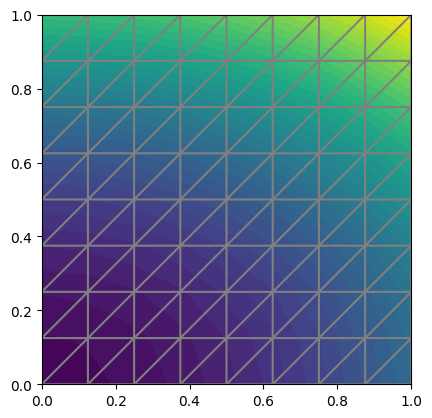

In [1]:
"""
FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.

  -Laplace(u) = f    in the unit square
            u = u_D  on the boundary

  u_D = 1 + x^2 + 2y^2
    f = -6
"""

from __future__ import print_function
from fenics import *
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution and mesh
plot(u)
plot(mesh)

# Save solution to file in VTK format
vtkfile = File('poisson/solution.pvd')
vtkfile << u

# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

# Hold plot
plt.show()

This code sets up and solves the Allen-Cahn equation for a phase field simulation using the FEniCS library. The simulation runs for a specified number of time steps, updating and plotting the phase field periodically. The initial condition is a sine function with small perturbations, and the solution is computed using the finite element method.

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a55c8cf853c08b5d075fd9dd73de3fe59a1252a2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_44]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.115158 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_97306e57896c09a96f55c99da7a21bec7c784777

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0513415 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

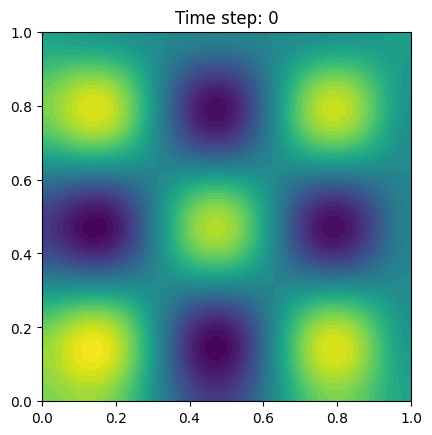

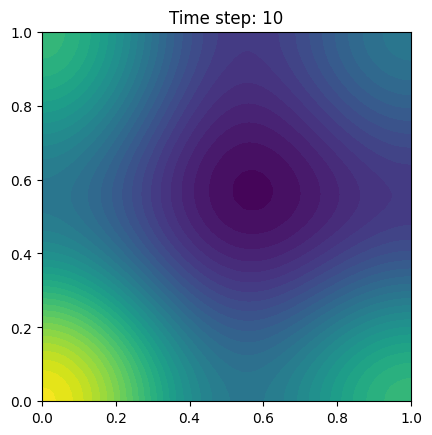

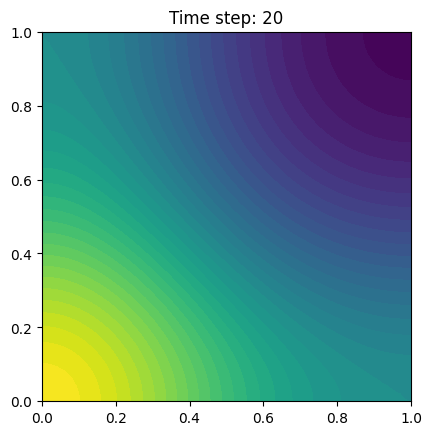

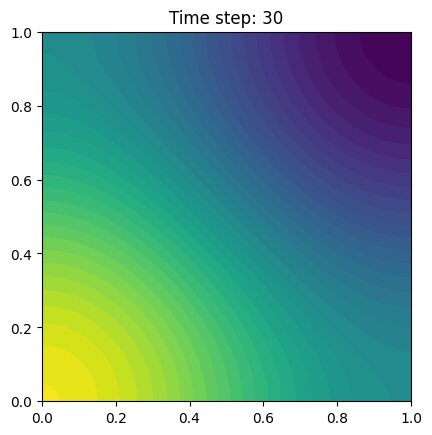

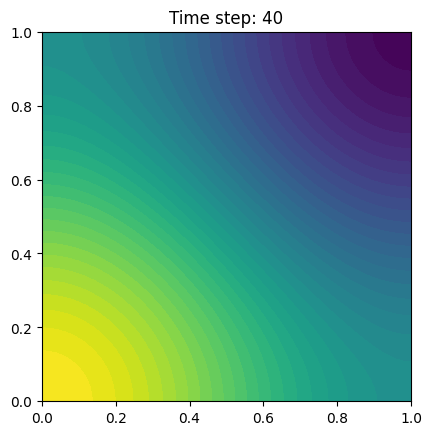

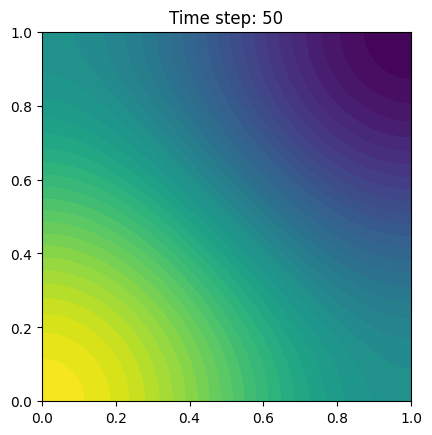

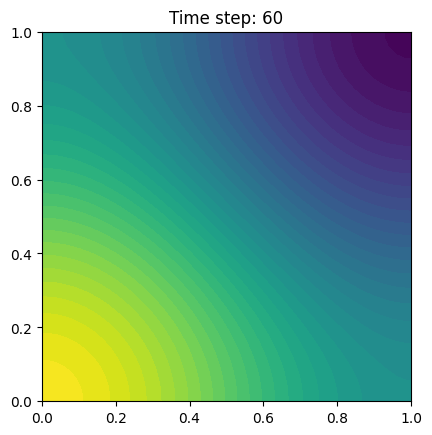

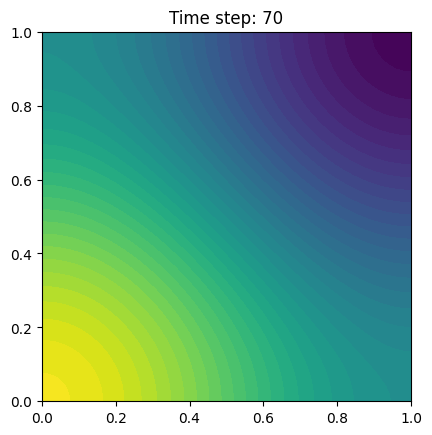

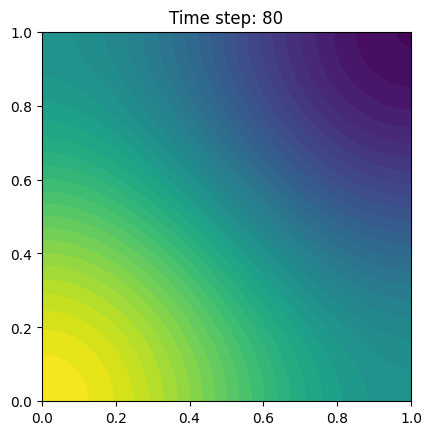

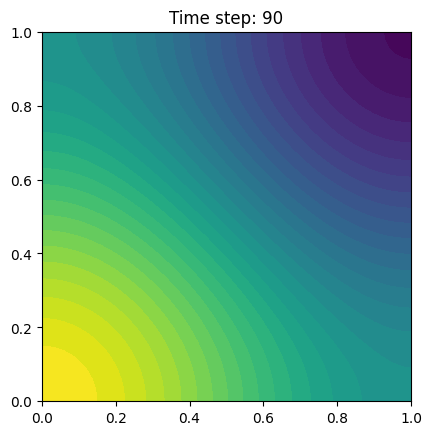

In [2]:
from fenics import *
import matplotlib.pyplot as plt

# Parameters
L = 1.0
dt = 0.01
num_steps = 100

# Create mesh and define function space
nx, ny = 50, 50
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Initial condition
phi = Function(V)
phi.interpolate(Expression('0.5 + 0.01*sin(10*x[0])*sin(10*x[1])', degree=2))

# Define weak form
phi_n = Function(V)
phi_n.assign(phi)
phi_trial = TrialFunction(V)
v = TestFunction(V)
f = phi_n * (1 - phi_n) * (0.5 - phi_n)
F = (phi_trial - phi_n) / dt * v * dx + L * f * v * dx + dot(grad(phi_trial), grad(v)) * dx

a, L = lhs(F), rhs(F)

# Time-stepping
for n in range(num_steps):
    solve(a == L, phi)
    phi_n.assign(phi)

    if n % 10 == 0:
        plt.figure()
        plot(phi)
        plt.title(f'Time step: {n}')
        plt.show()


Problem Description
The objective is to model crack propagation in a material using a phase field approach, which involves solving a system of coupled partial differential equations (PDEs) for the displacement field and the phase field. The phase field represents the state of the material, indicating intact or cracked regions. The displacement field describes the deformation of the material under applied loads.

Key Components and Methods
Governing Equations:

The displacement field
𝑢
u is governed by the equilibrium equation derived from the principle of virtual work.
The phase field
𝜙
ϕ evolves according to an energy minimization principle, incorporating the fracture energy and a length scale parameter.
Elasticity Parameters:

Young's Modulus

E and Poisson's Ratio
𝜈
 define the material's elastic properties.
The Lame parameters
𝜇
μ and
𝜆
λ are derived from
𝐸
E and
𝜈
ν.
Energy Functional:

The total energy functional includes the elastic energy, the fracture energy, and a degradation function that couples the displacement and phase fields.
Boundary and Initial Conditions:

Displacement boundary conditions are applied to simulate loading.
The phase field is initially set to represent an undamaged material.
Numerical Solution:

The finite element method (FEM) is used to discretize and solve the coupled PDEs.
The FEniCS library provides the computational framework for implementing the FEM.
Time-Stepping and Load Application:

The load is incrementally applied, and the system is solved iteratively for each time step.
Reaction forces are computed to generate the load-displacement curve, which provides insight into the material's response to loading and the progression of cracking.
Implementation Highlights
Mesh and Function Spaces:

A rectangular mesh is created, and function spaces for the displacement and phase fields are defined.
Weak Forms:

The weak forms of the displacement and phase field equations are derived and implemented.
These forms are integrated over the domain and solved iteratively.
Boundary Conditions:

Dirichlet boundary conditions fix displacements on one side and apply incremental loading on the opposite side.
Visualization:

The load-displacement curve is plotted to analyze the mechanical response.
The final phase field and displacement field are visualized to understand the crack propagation pattern.
Results and Analysis
The simulation provides a detailed analysis of how cracks initiate and propagate in the material under applied loading. The load-displacement curve offers insight into the material's mechanical properties, such as stiffness and fracture toughness. The final phase field visualization highlights the regions where cracks have formed and propagated, allowing for a better understanding of the fracture process.

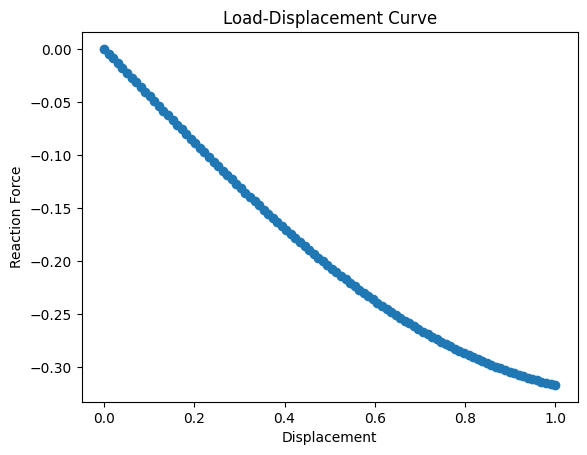

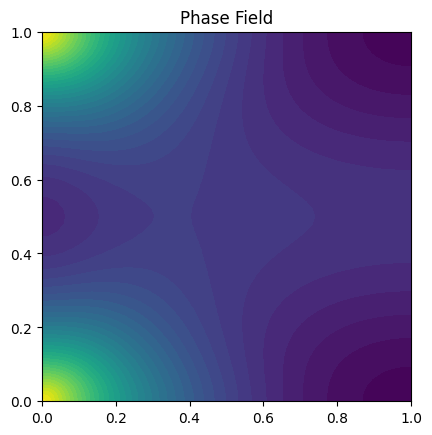

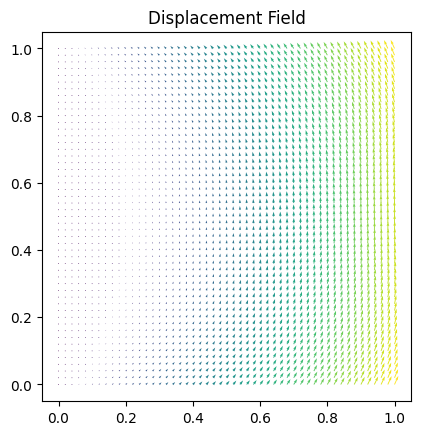

In [5]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

# Parameters
L = 1.0         # Length of the domain
H = 1.0         # Height of the domain
nx, ny = 50, 50 # Mesh resolution
E = 10.0        # Young's modulus
nu = 0.3        # Poisson's ratio
Gc = 1.0        # Fracture energy
ell = 0.1       # Length scale parameter for phase field
load_steps = 100 # Number of load steps
max_load = 1.0  # Maximum applied load
dt = 0.01       # Time step size
tolerance = 1e-5 # Convergence tolerance

# Create mesh and define function spaces
mesh = RectangleMesh(Point(0, 0), Point(L, H), nx, ny)
V = VectorFunctionSpace(mesh, 'P', 1)  # Displacement space
V_phi = FunctionSpace(mesh, 'P', 1)    # Phase field space

# Define functions
u = Function(V)       # Displacement field
u_trial = TrialFunction(V)
v = TestFunction(V)

phi = Function(V_phi) # Phase field
phi_trial = TrialFunction(V_phi)
w = TestFunction(V_phi)

# Elasticity parameters
mu = E / (2.0 * (1.0 + nu))
lambda_ = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

# Define strain and stress
def epsilon(u):
    return sym(grad(u))

def sigma(u, phi):
    return (1 - phi)**2 * (lambda_ * tr(epsilon(u)) * Identity(2) + 2.0 * mu * epsilon(u))

# Elastic energy density
psi = lambda u, phi: 0.5 * inner(sigma(u, phi), epsilon(u))

# Weak form for displacement
a_u = inner(sigma(u_trial, phi), epsilon(v)) * dx
L_u = dot(Constant((0, 0)), v) * dx

# Weak form for phase field
a_phi = (phi_trial * w + dt * Gc * (phi_trial * w / ell + ell * dot(grad(phi_trial), grad(w)))) * dx
L_phi = (phi * w + dt * psi(u, phi) * w) * dx

# Boundary conditions
def left(x, on_boundary):
    return on_boundary and near(x[0], 0)

def right(x, on_boundary):
    return on_boundary and near(x[0], L)

bc_u = [DirichletBC(V.sub(0), Constant(0), left),
        DirichletBC(V.sub(1), Constant(0), left)]

bc_phi = []

# Load application
load = Expression("t", t=0.0, degree=1)
bcu_load = DirichletBC(V.sub(1), load, right)
bc_u.append(bcu_load)

# Time-stepping and load application
load_values = np.linspace(0, max_load, load_steps)
displacement = []
reaction_force = []

for t in load_values:
    load.t = t
    solve(a_u == L_u, u, bc_u)
    solve(a_phi == L_phi, phi, bc_phi)

    # Reaction force (integral of the traction over the right boundary)
    ds_right = Measure('ds', domain=mesh, subdomain_data=MeshFunction('size_t', mesh, 1, 0))
    reaction = assemble(dot(sigma(u, phi) * FacetNormal(mesh), Constant((0, 1))) * ds_right)
    reaction_force.append(reaction)

    # Measure displacement at a specific point (e.g., top-right corner)
    displacement.append(u(Point(L, H))[1])

    if len(displacement) > 1 and abs(displacement[-1] - displacement[-2]) < tolerance:
        break

# Plot load-displacement curve
plt.figure()
plt.plot(displacement, reaction_force, 'o-')
plt.xlabel('Displacement')
plt.ylabel('Reaction Force')
plt.title('Load-Displacement Curve')
plt.show()

# Plot final phase field
plt.figure()
plot(phi, title='Phase Field')
plt.show()

# Plot final displacement field
plt.figure()
plot(u, title='Displacement Field')
plt.show()
